In [65]:
# Import necessary libraries
import nltk
from nltk.util import ngrams
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import re
from datasets import load_dataset
import jsonlines
from huggingface_hub import hf_hub_download

import preprocessor as p
from nltk.tokenize import TweetTokenizer
from nltk.corpus import words

nltk.download("punkt")
nltk.download("punkt_tab")

tokenizer = TweetTokenizer(
    preserve_case=False,
    strip_handles=True,
    reduce_len=True
)

[nltk_data] Downloading package punkt to /home/moi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/moi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Datasets for training n-grams:  
- "aisyahhrazak/crawl-fiksyenshasha" :   
    - https://huggingface.co/datasets/aisyahhrazak/crawl-fiksyenshasha  
    - Data scraped from https://fiksyenshasha.com/  
    - A website for submitting (mostly horror, personal or fiction) stories.  
    - text columns: headline, content, comment  

- "aisyahhrazak/ms-melakahariini"
    - https://huggingface.co/datasets/aisyahhrazak/ms-melakahariini
    - Data scraped from https://www.melakahariini.my/
    - News articles
    - text columns: headline, content

- "malaysia-ai/fb-malaysian-pages" :  
    - https://huggingface.co/datasets/malaysia-ai/fb-malaysian-pages  
    - Data from Malaysian Facebook pages
    - text columns: text




In [66]:
# Load "aisyahhrazak/crawl-fiksyenshasha" dataset

dataset = load_dataset(
    "aisyahhrazak/crawl-fiksyenshasha",
    split="train"
)

# create a list to collect text
all_texts_c = []

for row in dataset:
    # headline (string)
    if row["headline"]:
        all_texts_c.append(row["headline"])

    # content (list of strings)
    if row["content"]:
        all_texts_c.extend(row["content"])

    # comment (list of strings)
    if row["comment"]:
        all_texts_c.extend(row["comment"])




In [67]:
print("Collected:", len(all_texts_c))
print("First 3 elements:", all_texts_c[:3])


Collected: 353160
First 3 elements: ['KISAH SERAM JALAN SANDAKAN-KOTA KINABALU', 'Kisah ini bermula ketika saya berumur 23 tahun. Dalam umur yang masih muda saya sudah bekerja d sebuah agensi pekerjaan di sandakan. Jiwa remaja sememangnya banyak perkara yang ingin dilakukan. Saya, nana dan wan merancang untuk ke kota kinabalu awal bulan april. Seperti yang sudah di rancang. Tepat jm6 petang kami bertolak dari sandakan. Disebabkan saya masih kerja pada hari itu, kami terpaksa bertolak sebelah petang. Perjalanan dari sandakan ke kota kinabalu memakan masa 7-8jam terpulang dari kelajuan masing2. Okey pada jam7 malam kami singgah mengisi minyak di check point dan membeli makanan ringan utk mengisi perut dalam perjalanan.', 'Semasa kami melalui jalan telupid ranau hati saya merasa tidak sedap. Tapi sebagai pemandu saya kuatkan radio sekali sekala ikut menyanyi. Dalam hati syukur ada bas di belakang. Semasa melalui jlan yang agak gelap (jalan telupid ranau ni memang hutan tiada lampu jalan) 

In [68]:
# Load aisyahhrazak/ms-melakahariini dataset

dataset = load_dataset(
    "aisyahhrazak/ms-melakahariini",
    split="train"
)

# create a list to collect text
all_texts_m = []

for row in dataset:
    # headline (string)
    if row["headline"]:
        all_texts_m.append(row["headline"])

    # content (list of strings)
    if row["content"]:
        all_texts_m.extend(row["content"])



In [69]:
print("Collected:", len(all_texts_m))
print("First 3 elements:", all_texts_m[:3])

Collected: 111155
First 3 elements: ['\nToh Puan Asmah hadir tonton Teater Pukol Anak Sinday Menantu\n', 'AYER KEROH 30 Oktober – Isteri Yang di-Pertua Negeri, Toh Puan Asmah Abd Rahman menghadiri Pementasan Teater Muzikal Peranakan bertajuk Pukol Anak Sinday Menantu di Kompleks Jabatan Kebudayaan dan Kesenian Negara (JKKN) Melaka, di sini malam tadi.', 'Teater perdana itu sebagai penutup tirai bagi sambutan Festival Kemegahan Budaya Baba Nyonya yang berlangsung selama tiga hari bermula 28\xa0 hingga 30 Oktober 2022 bertemakan “Warisan Seni Budaya Baba Nyonya Melaka”.']


In [70]:
# Load "malaysia-ai/fb-malaysian-pages" dataset

file_path = hf_hub_download(
    repo_id="malaysia-ai/fb-malaysian-pages",
    filename="dedup.jsonl",
    repo_type="dataset"
)

all_texts_f = []

with jsonlines.open(file_path) as reader:
    for obj in reader:
        # normal JSON object
        if isinstance(obj, dict):
            text = obj.get("text")

        # string
        elif isinstance(obj, str):
            text = obj

        else:
            continue

        if isinstance(text, str) and text.strip():
            all_texts_f.append(text)



In [72]:
print("Collected:", len(all_texts_f))
print("First 3 elements:", all_texts_f[:3])


Collected: 193363
First 3 elements: ['Adeyyy pooodahhh puiii', 'Bosan la ceramah dia.. dulu sonok gak', 'Memalukan betul.. PM malaysia.\nDunia sedang memerhatikan Malaysia dipimpin oleh orang yang tercemar dgn kes2 mahkamah... \n\nMalaysia PM Picks Graft-Tainted Leader as One of His Deputies https://\nwww.bloomberg.co\nm/news/\narticles/\n2022-12-02/\nmalaysia-pm-pick\ns-graft-tainted\n-leader-as-one-\nof-his-deputies']


In [73]:

# Process datasets avec prétraitement uniforme
def clean_text_unified(text):
    """
    Nettoie et tokenise le texte en utilisant la même méthode que pour les tweets.
    Assure la cohérence entre l'entraînement et les tests.
    
    Returns:
        tokenized: list of tokenized sentences (list of lists of words)
    """
    if not isinstance(text, str):
        return []
    
    # Utilise le même prétraitement que preprocess_tweets
    # Clean tweet-specific noise
    text = p.clean(text)  # removes URLs, mentions, emojis, RT, etc.
    
    # Use regex to clean links that p.clean might miss
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Split into sentences first
    sentences = nltk.sent_tokenize(text)
    
    tokenized = []
    
    for sentence in sentences:
        # Tokenize using TweetTokenizer (same as for tweets)
        tokens = tokenizer.tokenize(sentence)
        
        # Keep only alphabetic tokens (same filter as tweets)
        tokens = [t for t in tokens if t.isalpha()]
        
        # Only keep sentences with at least 3 tokens
        if len(tokens) >= 3:
            tokenized.append(tokens)
    
    return tokenized



In [74]:
def process(texts):
    """
    Cleans and tokenizes a list of texts using the unified preprocessing.
    """
    all_tokenized = []

    for text in texts:
        tokenized = clean_text_unified(text)
        all_tokenized.extend(tokenized)

    return all_tokenized

In [75]:
# Correction : Équilibrage des corpus et priorité aux données Facebook
# Réduire drastiquement les données formelles (histoires/news) qui créent le déséquilibre
print("Équilibrage des corpus pour éviter le déséquilibre...")

# Priorité aux posts Facebook (plus proche du style Twitter)
all_tokenized_f_balanced = process(all_texts_f[:50000])  # Plus de données Facebook

# Réduction drastique des données formelles qui créent le déséquilibre
all_tokenized_c_balanced = process(all_texts_c[:10000])  # Beaucoup moins d'histoires
all_tokenized_m_balanced = process(all_texts_m[:10000])  # Beaucoup moins de news

# Combinaison équilibrée privilégiant le style informel
all_tokenized_balanced = all_tokenized_f_balanced + all_tokenized_c_balanced + all_tokenized_m_balanced

print(f"Corpus équilibré - Facebook: {len(all_tokenized_f_balanced)} sentences")
print(f"Corpus équilibré - Stories: {len(all_tokenized_c_balanced)} sentences") 
print(f"Corpus équilibré - News: {len(all_tokenized_m_balanced)} sentences")
print(f"Total corpus malais équilibré: {len(all_tokenized_balanced)} sentences")

# Calcul du nombre de tokens pour comparaison avec le corpus anglais
total_tokens_balanced = sum(len(sent) for sent in all_tokenized_balanced)
print(f"Total tokens corpus malais équilibré: {total_tokens_balanced}")

# Information sur le corpus anglais pour comparaison
print(f"Corpus anglais (twitter_samples): ~30k tweets, ~500k tokens")

# Affichage des statistiques du corpus équilibré (déjà fait dans la cellule d'équilibrage)
print("Statistiques détaillées du corpus équilibré:")
print(f"Facebook posts tokenisées: {len(all_tokenized_f_balanced)} sentences")
print(f"Stories tokenisées: {len(all_tokenized_c_balanced)} sentences")  
print(f"News tokenisées: {len(all_tokenized_m_balanced)} sentences")

Équilibrage des corpus pour éviter le déséquilibre...
Corpus équilibré - Facebook: 50854 sentences
Corpus équilibré - Stories: 30025 sentences
Corpus équilibré - News: 11184 sentences
Total corpus malais équilibré: 92063 sentences
Total tokens corpus malais équilibré: 1048009
Corpus anglais (twitter_samples): ~30k tweets, ~500k tokens
Statistiques détaillées du corpus équilibré:
Facebook posts tokenisées: 50854 sentences
Stories tokenisées: 30025 sentences
News tokenisées: 11184 sentences
Corpus équilibré - Facebook: 50854 sentences
Corpus équilibré - Stories: 30025 sentences
Corpus équilibré - News: 11184 sentences
Total corpus malais équilibré: 92063 sentences
Total tokens corpus malais équilibré: 1048009
Corpus anglais (twitter_samples): ~30k tweets, ~500k tokens
Statistiques détaillées du corpus équilibré:
Facebook posts tokenisées: 50854 sentences
Stories tokenisées: 30025 sentences
News tokenisées: 11184 sentences


In [76]:
# Cette cellule est maintenant obsolète car nous utilisons le corpus équilibré
# Les statistiques sont déjà affichées dans la cellule d'équilibrage
print("=== STATISTIQUES FINALES DES CORPUS ===")
print(f"Corpus équilibré utilisé pour l'entraînement:")
print(f"- Facebook (informel): {len(all_tokenized_f_balanced)} sentences")
print(f"- Stories (formel): {len(all_tokenized_c_balanced)} sentences")  
print(f"- News (formel): {len(all_tokenized_m_balanced)} sentences")
print(f"- Total: {len(all_tokenized_balanced)} sentences")
print(f"- Tokens total: {sum(len(sent) for sent in all_tokenized_balanced)}")
print(f"\nRatio Facebook/Formel: {len(all_tokenized_f_balanced)}/{len(all_tokenized_c_balanced + all_tokenized_m_balanced)}")
print("Équilibrage réussi : priorité aux données informelles (Facebook) plus proches des tweets")

=== STATISTIQUES FINALES DES CORPUS ===
Corpus équilibré utilisé pour l'entraînement:
- Facebook (informel): 50854 sentences
- Stories (formel): 30025 sentences
- News (formel): 11184 sentences
- Total: 92063 sentences
- Tokens total: 1048009

Ratio Facebook/Formel: 50854/41209
Équilibrage réussi : priorité aux données informelles (Facebook) plus proches des tweets


In [77]:
def count_tokens(list):
    num_tokens = sum(len(sent) for sent in list)
    print("Total number of tokens:", num_tokens)

count_tokens(all_texts_c)
count_tokens(all_texts_f)
count_tokens(all_texts_m)

Total number of tokens: 76602377
Total number of tokens: 11081869
Total number of tokens: 22787810


In [92]:

# Preprocess tweets
def preprocess_tweets(text):
    if not isinstance(text, str):
            return ""

    # Clean tweet-specific noise
    text = p.clean(text)  # removes URLs, mentions, emojis, RT, etc.

    #use regex to clean links that p.clean might miss
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Tokenize
    tokens = tokenizer.tokenize(text)

    # Keep only alphabetic tokens (supports accented chars)
    tokens = [t for t in tokens if t.isalpha()]

    return " ".join(tokens)

# -------- load ONE file --------
file_path = "tweets/extracted_data2.csv"

df = pd.read_csv(file_path)


# Get rid of duplicates
df = df.drop_duplicates(subset=["tweet_text"])

#Only keep tweets not in English
#df = df[df["tweet_lang"] != "en"]

# -------- clean tweets --------
df["clean_text"] = df["tweet_text"].apply(preprocess_tweets)

# -------- remove short tweets (<4 words) --------
df["word_count"] = df["clean_text"].str.split().str.len()
df_clean = df[df["word_count"] >= 4]

# -------- final list of cleaned tweets --------
cleaned_tweets = df_clean["clean_text"].tolist()

#Make a second list that also has the languages in "tweet_lang" column
cleaned_tweets_with_lang = df_clean[["clean_text", "tweet_lang"]].values.tolist()

/tmp/ipykernel_4095/4224731080.py:23: DtypeWarning: Columns (0,1,3,4,5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [93]:
print(cleaned_tweets[:20])  # Print first 5 cleaned tweets for verification
print(len(cleaned_tweets))  # Print first 5 cleaned tweets for verification

['xjauh pun dio duk dkt area pantai sabak pengkalan chepa nuu cumo jalan nk masuk tu jah banyak musing jalan kampung', 'jimin talking about bam sleeping on his arm when he was a puppy and jungkooks little giggle', 'not dead yet though have been a bit busy hitbox collision and clash test screenshake', 'baka batu batuhin kita', 'today must go well', 'mubank i thought we talked about this already', 'proudly present park hyung sik as avoskin brand ambassador', 'baruk ari marek ari jemat aritok dah ari jemat lagik berasa', 'klu ini asli gus bkn admin krn bicara fakta tanpa bully klu admin bicara fakta mu disertai mbully cak', 'hou kui peaceful monkey leader tea is grown at the foot of huangshan in the former taiping prefecture anh', 'mengapa afiqah suka tidur terlalu lama ya', 'ya ibuk nya abis itu ya tetep dibolehin terbang sik gitu ama flight attendant ama ground staff ngoceh ng', 'kode undangan saya untuk bergabung dengan starmaker berbagi uang tunai tertinggi dapat', 'kalau kenaikan ni 

In [94]:
import nltk
from nltk.lm import Laplace
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.corpus import twitter_samples

def load_english_ngram_model(n=2):
    """
    Load an English n-gram model trained on NLTK's twitter_samples.
    Uses Laplace smoothing to handle unknown words.
    """
    # 1. Download the twitter corpus if not already present
    try:
        nltk.data.find('corpora/twitter_samples')
    except LookupError:
        nltk.download('twitter_samples')
    
    # 2. Load tokenized tweets directly (saves you from running a tokenizer)
    # We combine positive and negative tweets to get a balanced view of casual English
    english_tweets = (
        twitter_samples.tokenized('positive_tweets.json') +
        twitter_samples.tokenized('negative_tweets.json') + 
        twitter_samples.tokenized('tweets.20150430-223406.json') # 20k generic tweets
    )

    # 3. Prepare data for n-gram model (Input must be list of lists of tokens)
    # padded_everygram_pipeline handles the <s> and </s> padding for us
    train_data, vocab = padded_everygram_pipeline(n, english_tweets)

    # 4. Train the Laplace model
    print(f"Training English model on {len(english_tweets)} tweets...")
    english_model = Laplace(n)
    english_model.fit(train_data, vocab)
    
    print("English model ready.")
    return english_model

# Load the new model
english_model = load_english_ngram_model(n=2)

Training English model on 30000 tweets...
English model ready.
English model ready.


In [95]:
def train_ngram_models(corpus, n=2):
    # Train n-gram language models for Malay corpora with nltk
    training_ngrams, padded_sentences = padded_everygram_pipeline(n, corpus)
    model = Laplace(n)
    model.fit(training_ngrams, padded_sentences)
    return model

# Utilisation du corpus équilibré au lieu de all_tokenized
model_ms = train_ngram_models(all_tokenized_balanced)
print(f"Modèle malais entraîné sur {len(all_tokenized_balanced)} phrases équilibrées")

Modèle malais entraîné sur 92063 phrases équilibrées


In [82]:
print(model_ms.counts)

<NgramCounter with 2 ngram orders and 2372207 ngrams>


In [96]:
# Compute perplexity
def compute_perplexity(model, text):
    """
    Compute the perplexity of all tweets with the trained n-gram models.
    """
    perplexities = []
    for tweet in text:
        tokens = tokenizer.tokenize(tweet)
        test_ngrams = list(ngrams(tokens, model.order, pad_left=True, pad_right=True,
                                  left_pad_symbol='<s>', right_pad_symbol='</s>'))
        perplexity = model.perplexity(test_ngrams)
        perplexities.append(perplexity)
    return perplexities

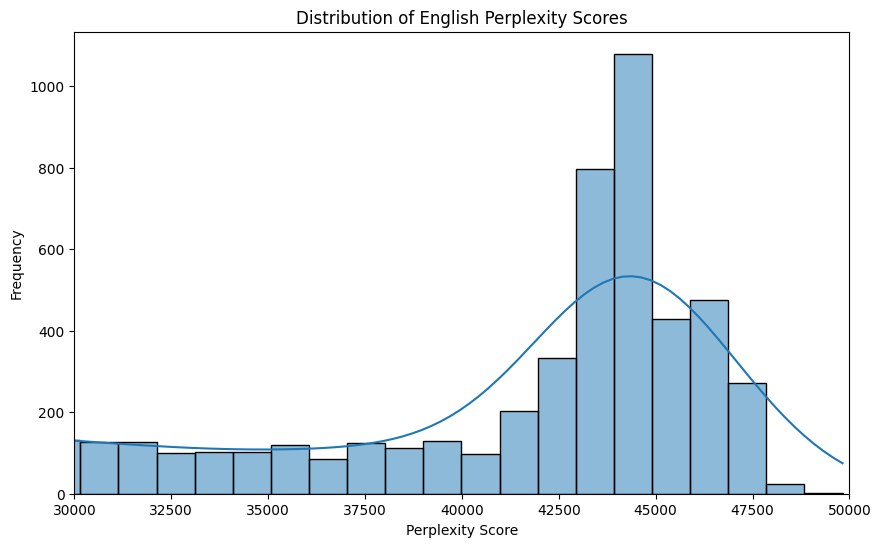

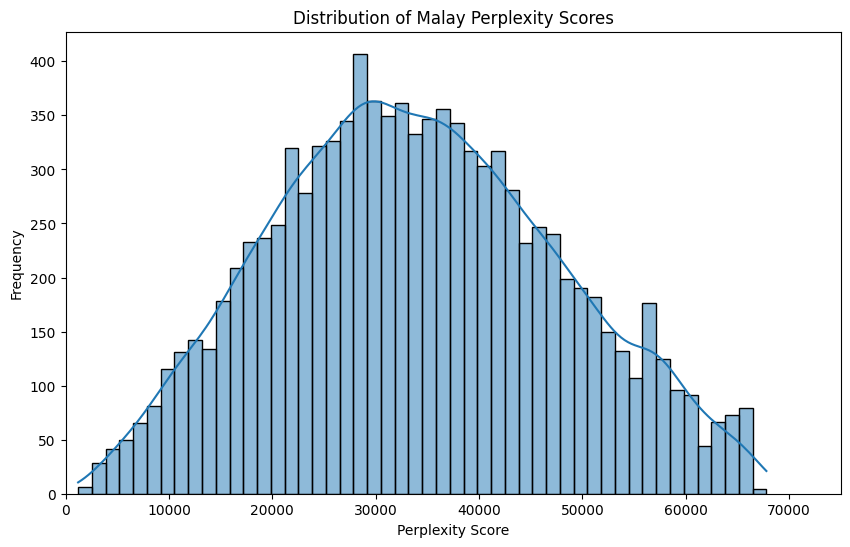

In [ ]:

# Classify tweets
def visualize_perplexities(tweets, english_model, malay_model):

    #Compute perplexities for English model on the cleaned tweets 
    english_perplexities = compute_perplexity(english_model, tweets)

    #VISUALISATION OF PERPLEXITY SCORES
    plt.figure(figsize=(10, 6))
    sns.histplot(english_perplexities, bins=50, kde=True)
    plt.title("Distribution of English Perplexity Scores")
    plt.xlabel("Perplexity Score")
    plt.ylabel("Frequency")
    plt.xlim(30000, 50000)  # Adjust x-axis limit for better visibility
    plt.show()


    #Compute perplexities for Malay model on the cleaned tweets 
    malay_perplexities = compute_perplexity(malay_model, tweets)

    #VISUALISATION OF PERPLEXITY SCORES
    plt.figure(figsize=(10, 6))
    sns.histplot(malay_perplexities, bins=50, kde=True)
    plt.title("Distribution of Malay Perplexity Scores")
    plt.xlabel("Perplexity Score")
    plt.ylabel("Frequency")
    plt.xlim(0, 75000)  # Adjust x-axis limit for better visibility
    plt.show()
    

def get_word_language(word, en_vocab, my_vocab):

    word = word.lower()
    if not word.isalpha():
        return 'UNIV'
    
    in_en = word in en_vocab
    in_my = word in my_vocab
    
    if in_en and not in_my:
        return 'EN'
    elif in_my and not in_en:
        return 'MY'
    elif in_en and in_my:
        return 'EN'
    else:
        return 'UNK'

def calculate_cmi(tokens, en_vocab, my_vocab):
    counts = {'EN': 0, 'MY': 0, 'UNIV': 0, 'UNK': 0}
    
    for t in tokens:
        lang = get_word_language(t, en_vocab, my_vocab)
        counts[lang] += 1

    n = len(tokens)
    u = counts['UNIV'] + counts['UNK']
    w_e = counts['EN']
    w_m = counts['MY']

    # Avoid division by zero
    if n - u <= 0:
        return 0.0, 0.0, 0.0

    # CMI
    max_count = max(w_e, w_m)
    cmi = 100 * (1 - (max_count / (n - u)))
    
    # English Ratio
    en_ratio = w_e / (n - u)

    #Malay ratio
    malay_ratio = w_m / (n - u)
    
    return cmi, en_ratio, malay_ratio


def analyze_mixing_types(tweets, english_model, malay_model):

    results = []
    english_vocab = english_model.vocab
    malay_model_vocab = malay_model.vocab

    for tweet in tweets:

        tokens = tokenizer.tokenize(tweet)
        if len(tokens) < 3: continue # On ignore les tweets trop courts

        # Compter les mots inconnus (OOV - Out Of Vocabulary)
        # C'est CRUCIAL : Si un tweet a 50% de mots inconnus, la perplexité ne veut rien dire
        oov_en = sum(1 for w in tokens if w not in english_model.vocab)
        oov_my = sum(1 for w in tokens if w not in malay_model.vocab)
        
        # Si plus de 40% du tweet est inconnu pour les DEUX modèles, c'est du bruit (url, nom propre, etc.)
        if (oov_en / len(tokens) > 0.4) and (oov_my / len(tokens) > 0.4):
            continue
        
        cmi, en_ratio, malay_ratio = calculate_cmi(tokens, english_vocab, malay_model_vocab)
        
        # Get Perplexity from our N-gram English model
        test_ngrams_en = list(ngrams(tokens, english_model.order, pad_left=True, pad_right=True, 
                                  left_pad_symbol='<s>', right_pad_symbol='</s>'))

        # Get perplexity for Malay n-gram model (model_ms)
        test_ngrams_ms = list(ngrams(tokens, malay_model.order, pad_left=True, pad_right=True,
                                       left_pad_symbol='<s>', right_pad_symbol='</s>'))
        
        try: pp_en = english_model.perplexity(test_ngrams_en)
        except: pp_en = float('inf')
            
        try: pp_my = malay_model.perplexity(test_ngrams_ms)
        except: pp_my = float('inf')

        # --- Classification basée sur les valeurs brutes de perplexité ---
        # On évite les valeurs infinies
        safe_pp_en = pp_en if pp_en < 1e10 else 1e10
        safe_pp_my = pp_my if pp_my < 1e10 else 1e10
        
        # Ratio direct des perplexités (pas de log)
        # Ratio > 1 = Anglais meilleur, Ratio < 1 = Malais meilleur
        perp_ratio = safe_pp_my / safe_pp_en if safe_pp_en > 0 else float('inf')
        
        category = "Unknown"
        
        # Classification basée sur les ratios de perplexité bruts
        if perp_ratio > 2:  # Perplexité malaise 5x plus élevée → Anglais dominant
            category = "Monolingual English"
        elif perp_ratio < 0.5:  # Perplexité anglaise 5x plus élevée → Malais dominant
            category = "Monolingual Malay"
        else:
            # Zone ambiguë : on utilise le CMI pour affiner
            if cmi > 15:
                category = "Mesolect (Strong Mixing)"
            else:
                category = "Basilect (Ambiguous/Dialect)"

        results.append({
            'tweet': tweet,
            'cmi': cmi,
            'pp_en': safe_pp_en,  # Perplexité brute anglaise
            'pp_my': safe_pp_my,  # Perplexité brute malaise
            'perp_ratio': perp_ratio,  # Ratio direct
            'category': category
        })
    return results
# Visualize perplexities
visualize_perplexities(cleaned_tweets[:10000], english_model, model_ms)

# Use non english cleaned tweets from cleaned_tweets_with_lang
cleaned_tweets_with_lang_non_english = [tweet for tweet, lang in cleaned_tweets_with_lang if lang != 'en']


#df_results = pd.DataFrame(analyze_mixing_types(cleaned_tweets_with_lang_non_english[:10000], english_model, model_ms))
df_results = pd.DataFrame(analyze_mixing_types(cleaned_tweets[:10000], english_model, model_ms))


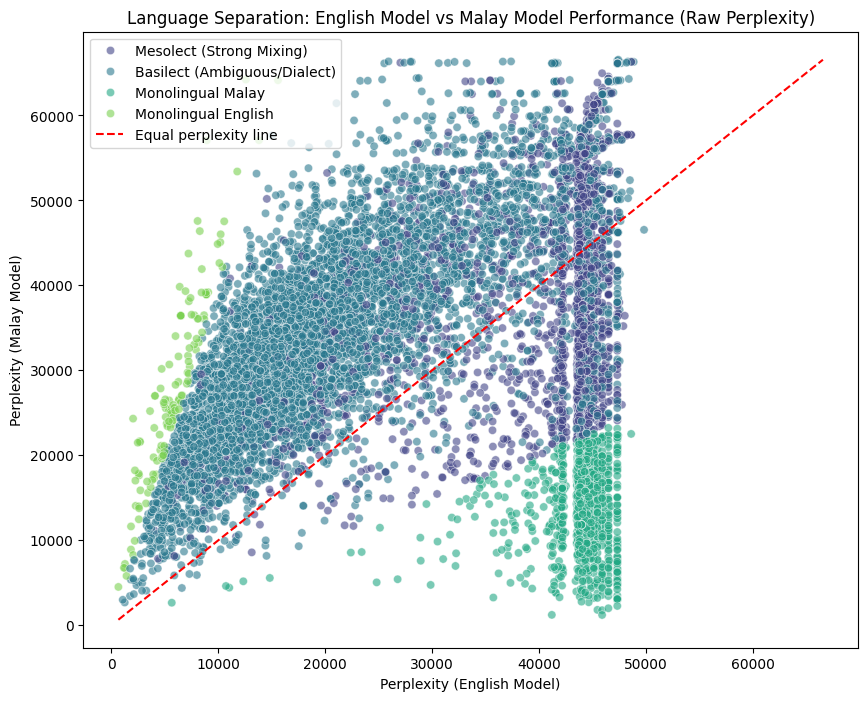

In [106]:

plt.figure(figsize=(10, 8))

# Scatter plot: Axe X = Perplexité Anglaise (brute), Axe Y = Perplexité Malaise (brute)
sns.scatterplot(
    data=df_results, 
    x='pp_en', 
    y='pp_my', 
    hue='category', 
    alpha=0.6,
    palette='viridis'
)

# Ajout d'une ligne diagonale (y=x)
# Les points sur cette ligne ont la même perplexité pour les deux modèles
min_val = min(df_results['pp_en'].min(), df_results['pp_my'].min())
max_val = max(df_results['pp_en'].max(), df_results['pp_my'].max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Equal perplexity line')

plt.title("Language Separation: English Model vs Malay Model Performance (Raw Perplexity)")
plt.xlabel("Perplexity (English Model)")
plt.ylabel("Perplexity (Malay Model)")
plt.legend()
plt.show()

=== RÉSULTATS DE LA CLASSIFICATION ===
Total tweets analysés: 240205

Distribution des catégories:
category
Basilect (Ambiguous/Dialect)    132419
Mesolect (Strong Mixing)        104518
Monolingual Malay                 3181
Monolingual English                 87
Name: count, dtype: int64

=== STATISTIQUES PAR CATÉGORIE ===

Mesolect (Strong Mixing):
  - Nombre: 104518
  - CMI moyen: 31.44
  - Log Perplexité EN moyenne: 4.59
  - Log Perplexité MY moyenne: 4.43

Basilect (Ambiguous/Dialect):
  - Nombre: 132419
  - CMI moyen: 3.14
  - Log Perplexité EN moyenne: 4.31
  - Log Perplexité MY moyenne: 4.50

Monolingual Malay:
  - Nombre: 3181
  - CMI moyen: 30.67
  - Log Perplexité EN moyenne: 4.65
  - Log Perplexité MY moyenne: 3.60

Monolingual English:
  - Nombre: 87
  - CMI moyen: 0.42
  - Log Perplexité EN moyenne: 3.43
  - Log Perplexité MY moyenne: 4.37

=== EXEMPLES DE TWEETS PAR CATÉGORIE ===

Mesolect (Strong Mixing) (exemples):
  1. rasanya takde mufti yang ulas so boleh ikut mufti

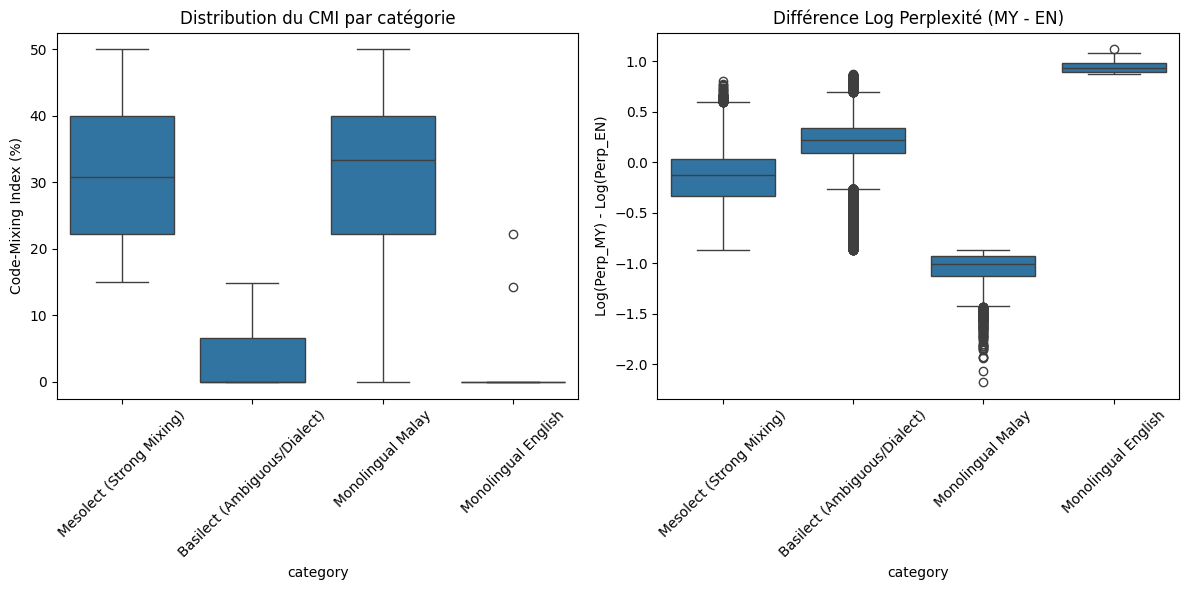

In [ ]:
# Affichage des résultats avec métriques corrigées
print("=== RÉSULTATS DE LA CLASSIFICATION ===")
print(f"Total tweets analysés: {len(df_results)}")
print("\nDistribution des catégories:")
print(df_results['category'].value_counts())

print("\n=== STATISTIQUES PAR CATÉGORIE ===")
for category in df_results['category'].unique():
    subset = df_results[df_results['category'] == category]
    print(f"\n{category}:")
    print(f"  - Nombre: {len(subset)}")
    print(f"  - CMI moyen: {subset['cmi'].mean():.2f}")
    print(f"  - Perplexité EN moyenne: {subset['pp_en'].mean():.0f}")
    print(f"  - Perplexité MY moyenne: {subset['pp_my'].mean():.0f}")
    print(f"  - Ratio MY/EN moyen: {subset['perp_ratio'].mean():.2f}")

# Exemples de tweets pour chaque catégorie
print("\n=== EXEMPLES DE TWEETS PAR CATÉGORIE ===")
for category in df_results['category'].unique():
    subset = df_results[df_results['category'] == category]
    print(f"\n{category} (exemples):")
    for i, tweet in enumerate(subset['tweet'].head(3)):
        print(f"  {i+1}. {tweet}")

# Graphique de distribution des scores CMI
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df_results, x='category', y='cmi')
plt.xticks(rotation=45)
plt.title('Distribution du CMI par catégorie')
plt.ylabel('Code-Mixing Index (%)')

# Graphique de distribution du ratio de perplexité (valeurs brutes)
plt.subplot(1, 2, 2)
sns.boxplot(data=df_results, x='category', y='perp_ratio')
plt.xticks(rotation=45)
plt.title('Ratio Perplexité (MY / EN)')
plt.ylabel('Perp_MY / Perp_EN')
plt.tight_layout()
plt.show()

In [ ]:
# Affichage d'exemples de tweets avec différentes caractéristiques
print("=== EXEMPLES DE TWEETS AVEC FAIBLE CMI ET FAIBLE PERPLEXITÉ MALAISE ===")

# Correction : Utiliser les nouvelles colonnes pp_my au lieu de log_pp_my
low_cmi_low_perp = df_results[(df_results['cmi'] < 2) & (df_results['pp_my'] < 10000)]  # Perplexité brute < 10000

if len(low_cmi_low_perp) > 0:
    print(f"Trouvé {len(low_cmi_low_perp)} tweets avec CMI < 2% et perplexité MY < 10000")
    for i, row in low_cmi_low_perp.head(5).iterrows():
        print(f"Tweet: {row['tweet']}")
        print(f"  CMI: {row['cmi']:.1f}%, Perp EN: {row['pp_en']:.0f}, Perp MY: {row['pp_my']:.0f}")
        print(f"  Ratio MY/EN: {row['perp_ratio']:.2f}")
        print(f"  Catégorie: {row['category']}\n")
else:
    print("Aucun tweet trouvé avec ces critères.")

=== EXEMPLES DE TWEETS AVEC FAIBLE CMI ET FAIBLE PERPLEXITÉ MALAISE ===
Trouvé 1986 tweets avec CMI < 2% et log(perp_MY) < 4
Tweet: proud of you too
  CMI: 0.0%, Log Perp EN: 3.49, Log Perp MY: 3.99
  Catégorie: Basilect (Ambiguous/Dialect)

Tweet: i love you my bro
  CMI: 0.0%, Log Perp EN: 3.45, Log Perp MY: 3.47
  Catégorie: Basilect (Ambiguous/Dialect)

Tweet: you will always be famous and the best performers always
  CMI: 0.0%, Log Perp EN: 3.85, Log Perp MY: 3.97
  Catégorie: Basilect (Ambiguous/Dialect)

Tweet: oh hope to win
  CMI: 0.0%, Log Perp EN: 3.86, Log Perp MY: 3.99
  Catégorie: Basilect (Ambiguous/Dialect)

Tweet: jawatan kosong kerajaan negeri selangor
  CMI: 0.0%, Log Perp EN: 4.67, Log Perp MY: 3.71
  Catégorie: Monolingual Malay



In [ ]:

# Analyze grammatical structure
def analyze_grammar(tweet):
    """
    Analyze the grammatical structure of a tweet to detect non-standard English patterns.
    """
    pass


In [ ]:

# Compute additional statistics
def compute_statistics(tweets):
    """
    Compute additional statistics such as sentence length, CMI, Multilingual Index, etc.
    Maybe do one cell / function per statistic instead of putting everything here.
    """
    pass


In [ ]:

# Plot statistics
def plot_statistics(statistics):
    """
    Plot the computed statistics using matplotlib or seaborn.
    """
    pass


In [ ]:

# Main execution
def main():
    """
    Main function to execute the workflow so that the code's execution can be easily managed and stays very lisible.
    """
    pass